In [ ]:
#Load some needed packages. (Previously needed to import before other packages or got error. Not sure if still an issue.)
from sklearn.model_selection import train_test_split #For reasons beyond the ken of mortal man, this needs to be loaded first or it will fail. Might be TF that it needs to be loaded before.
from sklearn import preprocessing
from sklearn.preprocessing import normalize

In [ ]:
#Mount Google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load some needed packages. 
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
#from sklearn.model_selection import train_test_split
#import sklearn
from matplotlib.ticker import MaxNLocator #Able to force plots to use integer ticks only.

from tensorflow import keras
from keras import Input, Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import concatenate

import ast as ast
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.patches as patches

import matplotlib as mpl

In [ ]:
#Define a function for evaluating the model.
def plot_learning_curve(history):
      fig, ax = plt.subplots(1, 2, figsize=(12, 4))
      ax[0].plot(history['loss'], label='training')
      ax[0].plot(history['val_loss'], label='validation')
      ax[0].set_title("Model losses")
      ax[0].set_xlabel("Epoch")
      ax[0].set_ylabel("Loss")
      #ax[0].set_yscale('log')
      ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
      ax[0].legend()

      ax[1].plot(history['accuracy'], label='training')
      ax[1].plot(history['val_accuracy'], label='validation')
      ax[1].set_title("Model accuracy")
      ax[1].set_xlabel("Epoch")
      ax[1].set_ylabel("Accuracy")
      ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
      ax[1].legend()
      plt.show()


In [ ]:
#Print drive contents as a check.
!ls "/content/drive/My Drive/Colab Notebooks/GMn_NN/"

GMn_SBS4_NN.ipynb      target_data_SBS4.npy
Preprocessing_SBS4.py  training_data_SBS4.npy


In [ ]:
#Load the training data and targets.
data = np.load("/content/drive/My Drive/Colab Notebooks/GMn_NN/training_data_SBS4.npy")
targets = np.load("/content/drive/My Drive/Colab Notebooks/GMn_NN/target_data_SBS4.npy")

#Remove all events where HCal cluster energy is 0.
#This method is way way way too slow.
#for i in range(0,len(data)):
#    if i%100==0:
#        print(i)
#    if data[i][0] == 0:
        #targets = np.delete(targets,i,0)
        #data = np.delete(data,i,0)

#Store the raw data so there is a copy that hasn't been normalized.
data_raw = data[:]

#Normalize the training data for NN learning.
data = normalize(data,axis=0)

print('data.shape = ',data.shape)
print('data = ',data)
print('data.dtype = ',data.dtype)

#Combine raw data and normalized data. This allows for keeping the raw and normalized data belonging to the same event together when splitting out training and test data sets. 
data_combined = zip(data_raw,data)
data_combined = list(data_combined)
data_combined = np.array(data_combined)
print('data_combined.shape = ',data_combined.shape)
print('data_combined = ',data_combined)

targets = targets.astype('float')
print('targets.shape = ',targets.shape)
print('targets = ',targets)
print('targets.dtype = ',targets.dtype)

# Count occurrence of element '1' in numpy array (number of 'true' elastic events).
count = np.count_nonzero(targets == 1)
print('Total occurences of "1" in array: ', count)

data.shape =  (2694333, 6)
data =  [[ 1.27459355e-04 -6.21675161e-04 -1.12289268e-03 -7.62614528e-04
   4.24105496e-04  5.61550250e-04]
 [ 8.91076252e-05 -6.42886388e-04 -2.05615183e-04 -1.16204619e-04
   1.06993808e-03  4.47386395e-04]
 [ 5.31758758e-05 -5.14020633e-04 -7.70093642e-04 -7.62614528e-04
   6.36362975e-04  4.97689199e-04]
 ...
 [ 1.74960307e-04 -9.63507359e-04 -7.70093642e-04 -6.06099763e-04
   7.14824324e-05  6.41516358e-04]
 [ 2.27223383e-04 -3.49086574e-04 -1.19345249e-03  1.30773632e-05
   5.22932388e-04  5.93089022e-04]
 [ 6.09778346e-04 -5.93443841e-04 -9.11213257e-04 -8.91896509e-04
   9.59979986e-05  5.15263401e-04]]
data.dtype =  float64
data_combined.shape =  (2694333, 2, 6)
data_combined =  [[[ 1.80130000e-02 -6.47617600e+01 -2.42753000e+00 -8.99810000e-01
    3.74948000e-01  1.02131700e+00]
  [ 1.27459355e-04 -6.21675161e-04 -1.12289268e-03 -7.62614528e-04
    4.24105496e-04  5.61550250e-04]]

 [[ 1.25930000e-02 -6.69713970e+01 -4.44510000e-01 -1.37110000e-01


In [ ]:
#Try to reduce the number of non-elastic events to help the model learn.
import random
targets_reduced = []
data_reduced = []

#Loop over the training data.
for i in range(0,len(targets)):
    #Keep any event that is elastic.
    if targets[i]==1:
        targets_reduced.append(targets[i])
        #data_reduced.append(data[i])
        data_reduced.append(data_combined[i])
    else:
        #Throw out some % of the non-elastic background data to help the model learn with a higher elastics ratio. Could also try to artificially add elastics instead.
        keep = random.uniform(0, 1)
        if keep>0.99:
            targets_reduced.append(targets[i])
            #data_reduced.append(data[i])
            data_reduced.append(data_combined[i])

#Make the background reduced training data and target sets into numpy arrays. 
targets_reduced = np.array(targets_reduced)
data_reduced = np.array(data_reduced)
print('targets_reduced.shape =',targets_reduced.shape)
print('data_reduced.shape =',data_reduced.shape)

# Count occurrence of element '1' in numpy array. Make sure same as above.
count = np.count_nonzero(targets_reduced == 1)
print('Total occurences of "1" in array: ', count)

targets_reduced.shape = (35017, 1)
data_reduced.shape = (35017, 2, 6)
Total occurences of "1" in array:  8204


In [ ]:
#Split data into training and test.
#data_train, data_test, targets_train, targets_test = train_test_split(data_reduced, targets_reduced, test_size=0.20)
data_train, data_test, targets_train, targets_test = train_test_split(data_reduced, targets_reduced, test_size=0.20)

print('data_train.shape = ',data_train.shape)
print('data_test.shape = ',data_test.shape)
print('targets_train.shape = ',targets_train.shape)
print('targets_test.shape = ',targets_test.shape)

print('data_train',data_train)

#Split back to raw and normalized data so the arrays are easier to work with.
data_train_raw = [row[0] for row in data_train]
data_train_raw = np.array(data_train_raw) 

data_train = [row[1] for row in data_train]
data_train = np.array(data_train)

data_test_raw = [row[0] for row in data_test]
data_test_raw = np.array(data_test_raw)

data_test = [row[1] for row in data_test]
data_test = np.array(data_test)

#This variable determines if we use any data from the electron arm (BigBite). 
#if use_bb = 1 use 4 HCal variables (cluster energy, and cluster time, cluster X-position, Y-position) plus 2 BB variables preshower energy and shower energy.
#if use_bb = 0 only use 4 HCal variables. 
use_bb = 0 #Use the BB ps/sh energies if this = 1.

if use_bb == 0:
#Try removing the BB variables from the training data to see if it can still learn.
    data_train_raw = np.hsplit(data_train_raw,np.array([4]))
    data_train_raw = np.array(data_train_raw[0])

    data_train = np.hsplit(data_train,np.array([4]))
    data_train = np.array(data_train[0])

    data_test_raw = np.hsplit(data_test_raw,np.array([4]))
    data_test_raw = np.array(data_test_raw[0])

    data_test = np.hsplit(data_test,np.array([4]))
    data_test = np.array(data_test[0])

print('type(data_test_raw) = ',type(data_train_raw))
print('data_train_raw.shape = ',data_train_raw.shape)
#print('data_test_raw = ',data_train_raw)

print('data_train.shape = ',data_train.shape)
#print('data_test = ',data_train)

print('data_test_raw.shape = ',data_test_raw.shape)
#print('data_test_raw = ',data_train_raw)

print('data_test.shape = ',data_test.shape)
#print('data_test = ',data_train)

#Normalize the training data for NN learning.
#data_train = normalize(data_train,axis=0)
#data_test = normalize(data_test,axis=0)

data_train.shape =  (28013, 2, 6)
data_test.shape =  (7004, 2, 6)
targets_train.shape =  (28013, 1)
targets_test.shape =  (7004, 1)
data_train [[[ 5.33000000e-03 -1.98185010e+01  7.75810000e-01 -4.42190000e-01
    2.59682000e-01  9.53703000e-01]
  [ 3.77148926e-05 -1.90246062e-04  3.58863276e-04 -3.74768582e-04
    2.93727566e-04  5.24374076e-04]]

 [[ 4.02280000e-02 -5.36071200e+01 -1.20721000e+00  1.67970000e-01
    7.46949000e-01  1.40890000e+00]
  [ 2.84651913e-04 -5.14597116e-04 -5.58414220e-04  1.42359345e-04
    8.44877627e-04  7.74654831e-04]]

 [[ 6.34040000e-02 -6.75226310e+01  4.06804000e-01 -2.89650000e-01
    7.18868000e-01  9.38860000e-01]
  [ 4.48644475e-04 -6.48177913e-04  1.88173672e-04 -2.45486600e-04
    8.13115072e-04  5.16212956e-04]]

 ...

 [[ 3.08340000e-02 -6.10704190e+01 -2.58007000e+00 -2.89650000e-01
    1.03512200e+00  1.43301500e+00]
  [ 2.18180300e-04 -5.86240438e-04 -1.19345249e-03 -2.45486600e-04
    1.17083150e-03  7.87913970e-04]]

 [[ 8.28500000e-03 

In [ ]:
model = Sequential() #Define the model object

if use_bb:
    #Dense NN to identify elastic events.
    model.add(tf.keras.layers.Dense(128, input_shape=(6,), activation="relu"))
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    #model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(tf.keras.optimizers.Adam(lr=0.001),loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

if use_bb==0:
    #Dense NN to identify elastic events.
    model.add(tf.keras.layers.Dense(512, input_shape=(4,), activation="relu"))
    model.add(tf.keras.layers.Dense(1024, activation="relu"))
    #model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

#Print summary of model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               2560      
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Train the model to identify elastic events.
if use_bb:
    results = model.fit(data_train, targets_train, epochs=50, batch_size=128, validation_split=0.10)

if use_bb == 0:
    results = model.fit(data_train, targets_train, epochs=150, batch_size=64, validation_split=0.10)  

scores = model.evaluate(data_test, targets_test)

Epoch 1/150
394/394 [==============================] - 9s 21ms/step - loss: 0.1861 - accuracy: 0.7642 - val_loss: 0.1765 - val_accuracy: 0.7709
Epoch 2/150
394/394 [==============================] - 8s 21ms/step - loss: 0.1797 - accuracy: 0.7654 - val_loss: 0.1764 - val_accuracy: 0.7709
Epoch 3/150
394/394 [==============================] - 8s 21ms/step - loss: 0.1794 - accuracy: 0.7654 - val_loss: 0.1763 - val_accuracy: 0.7709
Epoch 4/150
394/394 [==============================] - 8s 21ms/step - loss: 0.1793 - accuracy: 0.7654 - val_loss: 0.1760 - val_accuracy: 0.7709
Epoch 5/150
394/394 [==============================] - 8s 21ms/step - loss: 0.1789 - accuracy: 0.7654 - val_loss: 0.1757 - val_accuracy: 0.7709
Epoch 6/150
394/394 [==============================] - 8s 21ms/step - loss: 0.1784 - accuracy: 0.7654 - val_loss: 0.1749 - val_accuracy: 0.7709
Epoch 7/150
394/394 [==============================] - 8s 20ms/step - loss: 0.1773 - accuracy: 0.7654 - val_loss: 0.1732 - val_accuracy:

test loss, test acc: [0.1069624200463295, 0.8379497528076172]


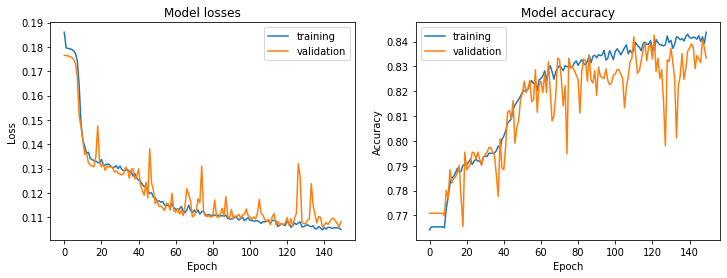

In [ ]:
#Print the training loss curves and accuracy.
print("test loss, test acc:", scores)

plot_learning_curve(results.history)

predictions.shape (7004, 1)
predictions[0] [0.2573231]
predictions [[2.57323086e-01]
 [3.33753824e-02]
 [3.45219761e-01]
 ...
 [6.53981864e-02]
 [7.06671053e-05]
 [1.02363825e-02]]
type(predictions) <class 'numpy.ndarray'>


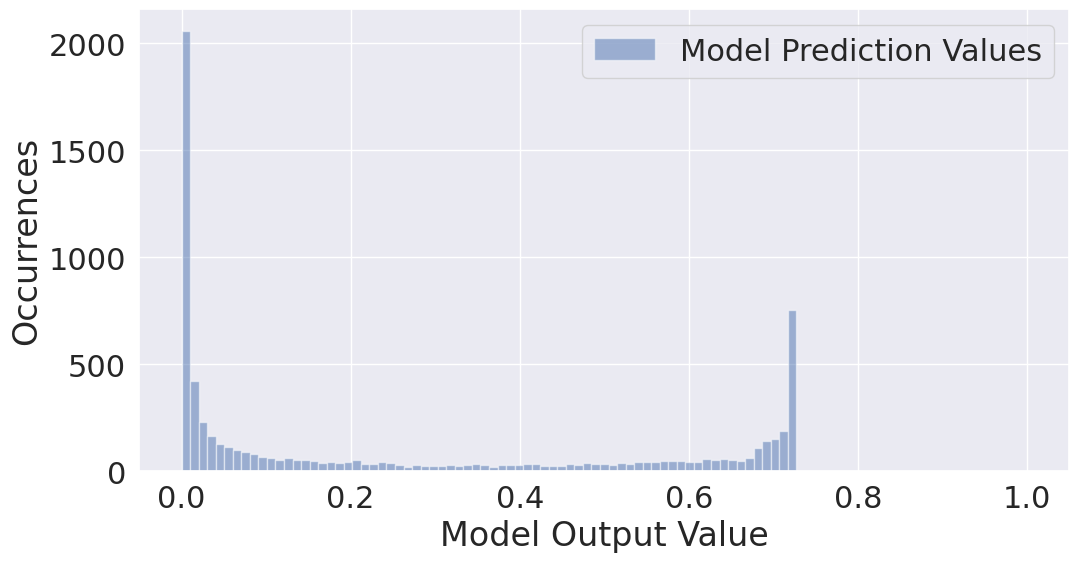

correctly_predicted.shape =  (7004,)
nother_pred = 4858
nelastic_pred = 2146
nother_cuts = 5357
nelastic_cuts = 1647
true_elastic = 1329
true_other = 4540
false_elastic = 817
false_other = 318
Percent of elastics detected by model = 80.69216757741347

Confusion Matrix with fADC Integral Threshold =
 [['true_elastic = 1329' 'false_elastic = 817']
 ['false_other = 318' 'true_other = 4540']]
Correctly identified  84.75 % of non-elastics as non-elastics.
Inorrectly identified  19.31 % of elastics as non-elastics.
Correctly identified  80.69 % of elastics as elastics.
Incorrectly identified  15.25 % of non-elastics  as elastics.
Accepted data = 30.63963449457453 %
Data reduction factor = 3.263746505125815


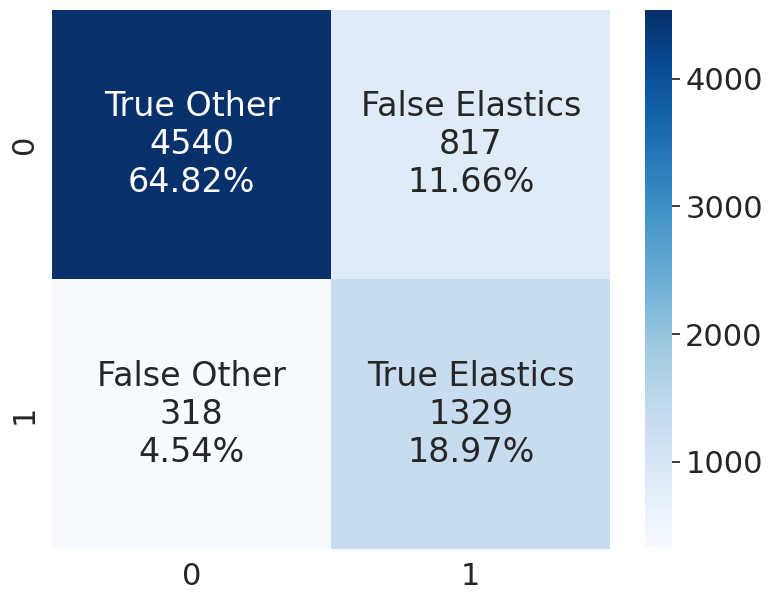

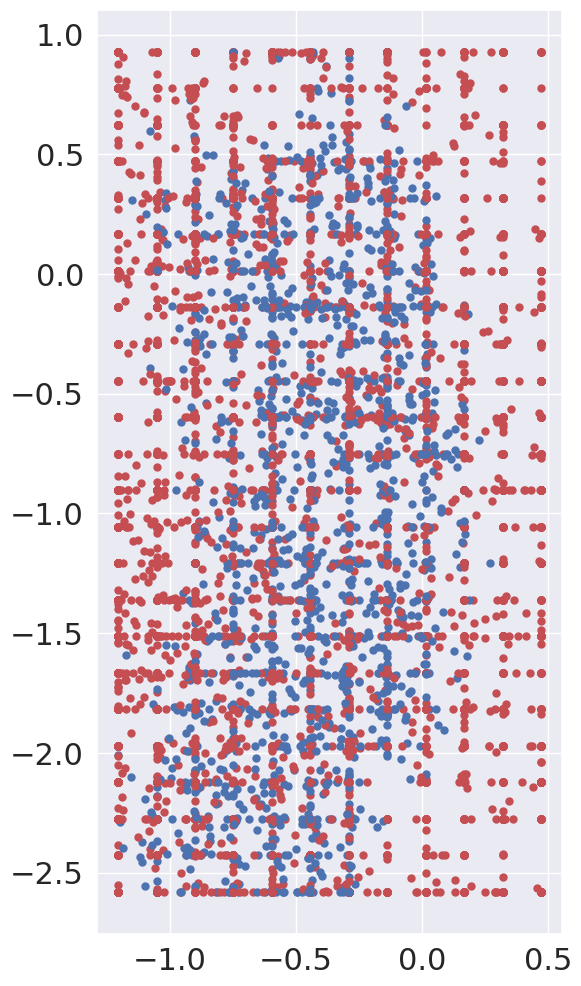

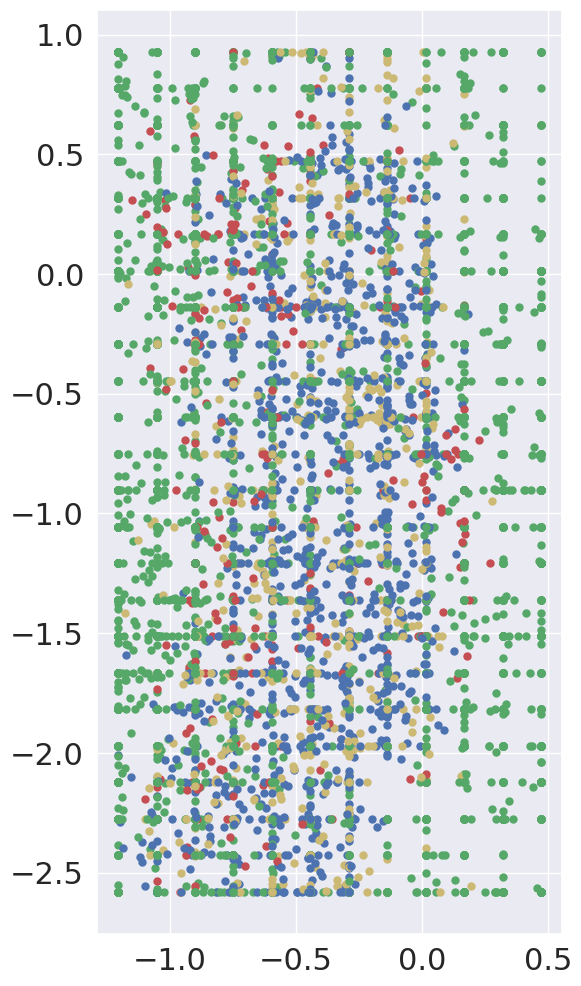

In [ ]:
# make class predictions with the model on the test data.
predictions = model.predict(data_test)
print('predictions.shape',predictions.shape)
print('predictions[0]',predictions[0])
print('predictions',predictions)
print('type(predictions)',type(predictions))

#Create a histogram of the model outputs before any rounding.
xaxis1 =predictions 
yaxis1 = np.ones(xaxis1.shape[0])

fig, ax = plt.subplots(figsize=(12,6))

bins1 = np.linspace(0, 1, 100)
hist1 = ax.hist(xaxis1,bins1,alpha=0.5,weights=yaxis1,label='Model Prediction Values')
ax.set_ylabel('Occurrences')
ax.set_xlabel('Model Output Value')
#ax.set_yscale('log')
ax.legend(loc='upper right')

plt.show()

#Create array for correct prediction. Not currently used. 
correctly_predicted = np.zeros(predictions.shape[0]) 
print('correctly_predicted.shape = ',correctly_predicted.shape)

#Define variables for the 'true' number of elastic and non-elastic events from traditional cuts as well as the model predictions for these numbers.
nelastic_pred = 0
nother_pred = 0

nelastic_cuts = 0
nother_cuts = 0

#Create variables to count the true and false elastic and non-elastic events.
true_elastic = 0
false_elastic = 0
true_other = 0
false_other = 0

#Arrays to sort various types of data whether correctly or incorrectly predicted.
true_elastic_arr = []
false_elastic_arr = []  
true_other_arr = []  
false_other_arr = []  

#Loop over the data and classify correct and incorrect predictions.
for event in range(predictions.shape[0]):
    predictions[event] = np.round_(predictions[event])
    if predictions[event]==0:
        nother_pred = nother_pred+1
        if targets_test[event]==0:
            true_other = true_other+1
            true_other_arr.append(data_test_raw[event])
            #correctly_predicted[event] = 1
        else:
            false_other = false_other+1
            false_other_arr.append(data_test_raw[event])
            #correctly_predicted[event] = 0
    if predictions[event]==1:
        nelastic_pred = nelastic_pred+1
        if targets_test[event]==1:
            true_elastic = true_elastic+1
            true_elastic_arr.append(data_test_raw[event])
            #correctly_predicted[event] = 1
        else:
            false_elastic = false_elastic+1
            false_elastic_arr.append(data_test_raw[event])
            #correctly_predicted[event] = 0
    if targets_test[event]==0:
        nother_cuts = nother_cuts+1
    if targets_test[event]==1:
        nelastic_cuts = nelastic_cuts+1
    if predictions[event]==targets_test[event]:
        correctly_predicted[event]=1

#Print results.
print('nother_pred =',nother_pred)
print('nelastic_pred =',nelastic_pred)
print('nother_cuts =',nother_cuts)
print('nelastic_cuts =',nelastic_cuts)

print('true_elastic =',true_elastic)
print('true_other =',true_other)
print('false_elastic =',false_elastic)
print('false_other =',false_other)

print('Percent of elastics detected by model =',(true_elastic/nelastic_cuts)*100)

#Calculate the percentage of each type of event correctly and incorrectly identified.
confusion_matrix_thr = ['true_elastic = '+str(true_elastic),'false_elastic = '+str(false_elastic),'false_other = '+str(false_other),'true_other = '+str(true_other)]
confusion_matrix_thr = np.reshape(confusion_matrix_thr,(2,2))
print('\nConfusion Matrix with fADC Integral Threshold =\n',confusion_matrix_thr)
print('Correctly identified ',round((true_other/nother_cuts)*100,2),'% of non-elastics as non-elastics.')
print('Inorrectly identified ',round((false_other/nelastic_cuts)*100,2),'% of elastics as non-elastics.')
print('Correctly identified ',round((true_elastic/nelastic_cuts)*100,2),'% of elastics as elastics.')
print('Incorrectly identified ',round((false_elastic/nother_cuts)*100,2),'% of non-elastics  as elastics.')

#This is currently not very meaningful as we are only running the model on 1% of the total data set.
accepted_data = (true_elastic+false_elastic)/(nelastic_cuts+nother_cuts)  
print('Accepted data =',accepted_data*100,'%')
print('Data reduction factor =',1/accepted_data)

#Plot normal confusion matrix.
cnf_mtx1 = confusion_matrix(targets_test, predictions)

group_names = ['True Other','False Elastics','False Other','True Elastics']
group_counts = ["{0:0.0f}".format(value) for value in cnf_mtx1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_mtx1.flatten()/np.sum(cnf_mtx1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#Plot nice looking confusion matrix.
plt.figure(figsize=(9, 7))   #One of these lines changed matplotlib output to seaborn type I think.
sn.set(font_scale=2.)     #One of these lines changed matplotlib output to seaborn type I think.
sn.heatmap(cnf_mtx1, annot=labels, fmt='', cmap='Blues',xticklabels=True,yticklabels=True)

#Plot the 'true' values for each event on the surface of the HCal detector.
# Create figure and axes.
fig, ax = plt.subplots(figsize=(6,12))

#Grab the x and y HCal position variables from the array. Recall x is vertical and y horizontal.
if use_bb:    
    x_list = [x for [a,b,x,y,c,d] in data_test_raw]
    y_list = [y for [a,b,x,y,c,d] in data_test_raw]

if use_bb==0:
    x_list = [x for [a,b,x,y] in data_test_raw]
    y_list = [y for [a,b,x,y] in data_test_raw]

#Plot the data points.
for i in range(0,len(targets_test)):
    #Elastic events.
    if targets_test[i]==1:
         plt.plot(y_list[i], x_list[i],'bo',markersize=5)
    #Non-elastic events.
    else:
        plt.plot(y_list[i], x_list[i],'ro',markersize=5)

plt.show()

#Plot the predicted values for each event.
# Create figure and axes
fig, ax = plt.subplots(figsize=(6,12))

#Grab the x and y variables from the array. Recall x is vertical and y horizontal.
if use_bb:    
    x_list = [x for [a,b,x,y,c,d] in data_test_raw]
    y_list = [y for [a,b,x,y,c,d] in data_test_raw]

if use_bb==0:
    x_list = [x for [a,b,x,y] in data_test_raw]
    y_list = [y for [a,b,x,y] in data_test_raw]

#Plot the data points. Use colors to show if prediction was correct or incorrect. 
for i in range(0,len(targets_test)):
    #True elastics.
    if targets_test[i]==1 and predictions[i]==1:
         plt.plot(y_list[i], x_list[i],'bo',markersize=5)
    #False non-elastics. Dangerous!
    elif targets_test[i]==1 and predictions[i]==0:
        plt.plot(y_list[i], x_list[i],'ro',markersize=5)
    #True non-elastics.
    elif targets_test[i]==0 and predictions[i]==0:
        plt.plot(y_list[i], x_list[i],'go',markersize=5)
    #False elastics
    elif targets_test[i]==0 and predictions[i]==1:
        plt.plot(y_list[i], x_list[i],'yo',markersize=5)

plt.show()

true_elastic_arr.shape= (1329, 4)
false_elastic_arr.shape= (817, 4)
true_other_arr.shape= (4540, 4)
false_other_arr.shape= (318, 4)
true_elastic_eng.shape= (1329, 1)
true_elastic_eng= [[0.063384]
 [0.07377 ]
 [0.087174]
 ...
 [0.089244]
 [0.182418]
 [0.068567]]
true_elastic_time.shape= (1329, 1)
true_elastic_x.shape= (1329, 1)
true_elastic_y.shape= (1329, 1)
true_elastic_ps.shape= (1329, 0)
true_elastic_sh.shape= (1329, 0)


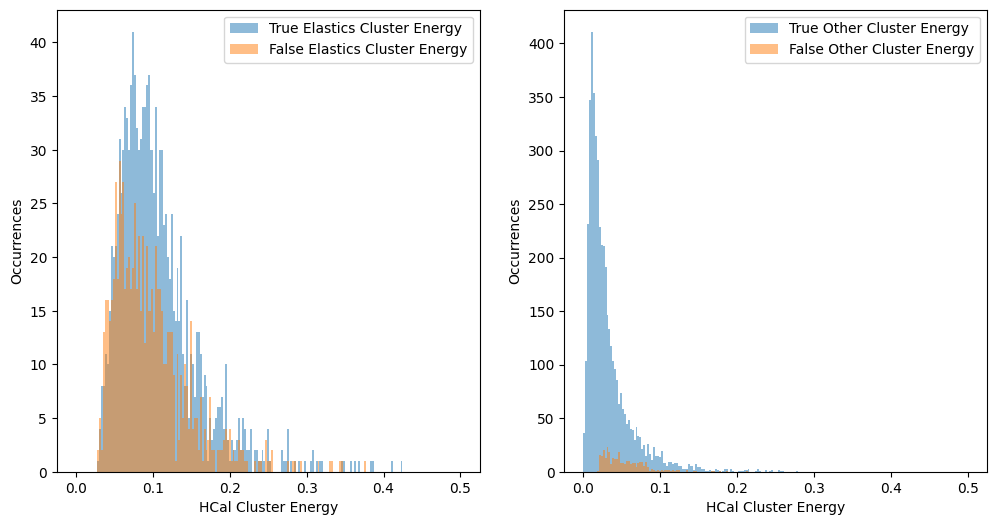

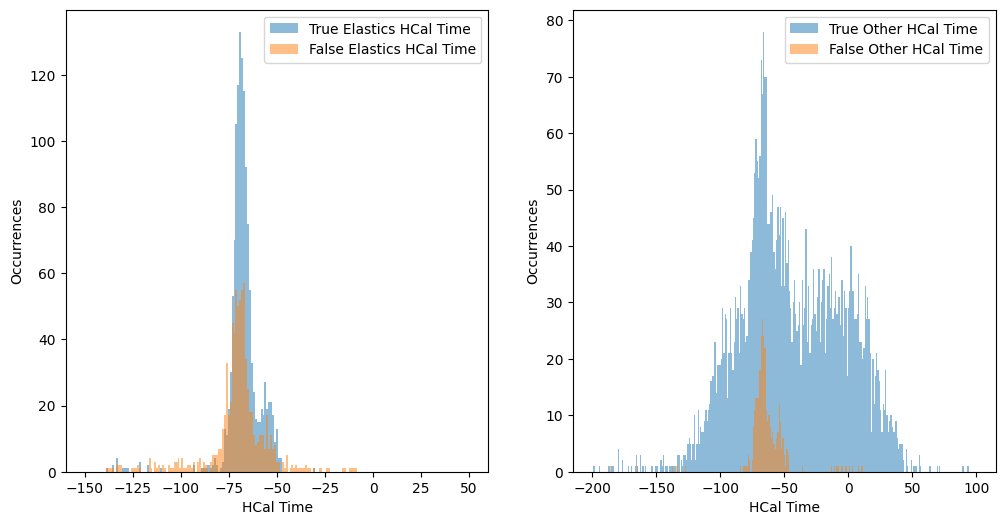

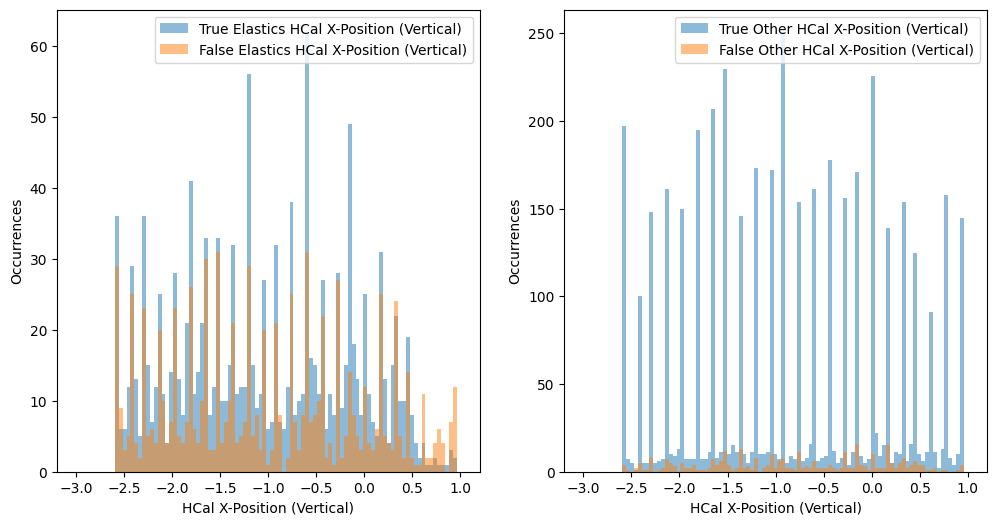

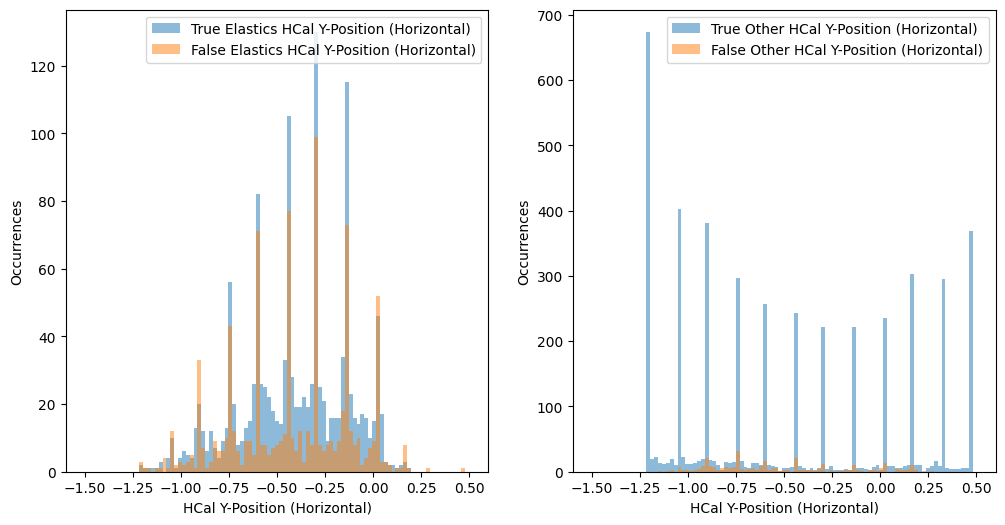

In [ ]:
#Make plots showing correctly and incorrectly identified events versus the training variables to find patterns.

true_elastic_arr = np.array(true_elastic_arr)
false_elastic_arr = np.array(false_elastic_arr)
true_other_arr = np.array(true_other_arr)
false_other_arr = np.array(false_other_arr)

print('true_elastic_arr.shape=',true_elastic_arr.shape)
print('false_elastic_arr.shape=',false_elastic_arr.shape)
print('true_other_arr.shape=',true_other_arr.shape)
print('false_other_arr.shape=',false_other_arr.shape)

#Split into individual training variables.
true_elastic_arr_temp = np.hsplit(true_elastic_arr,np.array([1,2,3,4,5,6]))
true_elastic_eng = np.array(true_elastic_arr_temp[0])
true_elastic_time = np.array(true_elastic_arr_temp[1])
true_elastic_x = np.array(true_elastic_arr_temp[2])
true_elastic_y = np.array(true_elastic_arr_temp[3])
true_elastic_ps = np.array(true_elastic_arr_temp[4])
true_elastic_sh = np.array(true_elastic_arr_temp[5])

print('true_elastic_eng.shape=',true_elastic_eng.shape)
print('true_elastic_eng=',true_elastic_eng)
print('true_elastic_time.shape=',true_elastic_time.shape)
print('true_elastic_x.shape=',true_elastic_x.shape)
print('true_elastic_y.shape=',true_elastic_y.shape)
print('true_elastic_ps.shape=',true_elastic_ps.shape)
print('true_elastic_sh.shape=',true_elastic_sh.shape)

false_elastic_arr_temp = np.hsplit(false_elastic_arr,np.array([1,2,3,4,5,6]))
false_elastic_eng = np.array(false_elastic_arr_temp[0])
false_elastic_time = np.array(false_elastic_arr_temp[1])
false_elastic_x = np.array(false_elastic_arr_temp[2])
false_elastic_y = np.array(false_elastic_arr_temp[3])
false_elastic_ps = np.array(false_elastic_arr_temp[4])
false_elastic_sh = np.array(false_elastic_arr_temp[5])

true_other_arr_temp = np.hsplit(true_other_arr,np.array([1,2,3,4,5,6]))
true_other_eng = np.array(true_other_arr_temp[0])
true_other_time = np.array(true_other_arr_temp[1])
true_other_x = np.array(true_other_arr_temp[2])
true_other_y = np.array(true_other_arr_temp[3])
true_other_ps = np.array(true_other_arr_temp[4])
true_other_sh = np.array(true_other_arr_temp[5])

false_other_arr_temp = np.hsplit(false_other_arr,np.array([1,2,3,4,5,6]))
false_other_eng = np.array(false_other_arr_temp[0])
false_other_time = np.array(false_other_arr_temp[1])
false_other_x = np.array(false_other_arr_temp[2])
false_other_y = np.array(false_other_arr_temp[3])
false_other_ps = np.array(false_other_arr_temp[4])
false_other_sh = np.array(false_other_arr_temp[5])

#print(results.shape,len(results))
#data_train_raw = np.hsplit(data_train_raw,np.array([4]))
#data_train_raw = np.array(data_train_raw[0])

mpl.rc_file_defaults()#Returns Matplotlib to defaults.

#Plot the HCal energy distributions of correctly and incorrectly identified events.
xaxis1 =true_elastic_eng 
yaxis1 = np.ones(xaxis1.shape[0])

xaxis2 =false_elastic_eng 
yaxis2 = np.ones(xaxis2.shape[0])

xaxis3 =true_other_eng
yaxis3 = np.ones(xaxis3.shape[0])

xaxis4 =false_other_eng 
yaxis4 = np.ones(xaxis4.shape[0])

fig, ax = plt.subplots(1,2,figsize=(12,6))

bins1 = np.linspace(0, 0.5, 200)
hist1 = ax[0].hist(xaxis1,bins1,alpha=0.5,weights=yaxis1,label='True Elastics Cluster Energy')
hist2 = ax[0].hist(xaxis2,bins1,alpha=0.5,weights=yaxis2,label='False Elastics Cluster Energy')
ax[0].set_ylabel('Occurrences')
ax[0].set_xlabel('HCal Cluster Energy')
#ax[0].set_yscale('log')
ax[0].legend(loc='upper right')

bins2 = np.linspace(0, 0.5, 200)
hist3 = ax[1].hist(xaxis3,bins2,alpha=0.5,weights=yaxis3,label='True Other Cluster Energy')
hist4 = ax[1].hist(xaxis4,bins2,alpha=0.5,weights=yaxis4,label='False Other Cluster Energy')
ax[1].set_ylabel('Occurrences')
ax[1].set_xlabel('HCal Cluster Energy')
#ax[1].set_yscale('log')
ax[1].legend(loc='upper right')

plt.show()

#Plot the HCal timing distributions of correctly and incorrectly identified events.
xaxis1 =true_elastic_time 
yaxis1 = np.ones(xaxis1.shape[0])

xaxis2 =false_elastic_time 
yaxis2 = np.ones(xaxis2.shape[0])

xaxis3 =true_other_time
yaxis3 = np.ones(xaxis3.shape[0])

xaxis4 =false_other_time 
yaxis4 = np.ones(xaxis4.shape[0])

fig, ax = plt.subplots(1,2,figsize=(12,6))

bins1 = np.linspace(-150, 50, 200)
hist1 = ax[0].hist(xaxis1,bins1,alpha=0.5,weights=yaxis1,label='True Elastics HCal Time')
hist2 = ax[0].hist(xaxis2,bins1,alpha=0.5,weights=yaxis2,label='False Elastics HCal Time')
ax[0].set_ylabel('Occurrences')
ax[0].set_xlabel('HCal Time')
#ax[0].set_yscale('log')
ax[0].legend(loc='upper right')

bins2 = np.linspace(-200, 100, 300)
hist3 = ax[1].hist(xaxis3,bins2,alpha=0.5,weights=yaxis3,label='True Other HCal Time')
hist4 = ax[1].hist(xaxis4,bins2,alpha=0.5,weights=yaxis4,label='False Other HCal Time')
ax[1].set_ylabel('Occurrences')
ax[1].set_xlabel('HCal Time')
#ax[1].set_yscale('log')
ax[1].legend(loc='upper right')

plt.show()

#Plot the HCal X-position (vertical) distributions of correctly and incorrectly identified events.
xaxis1 =true_elastic_x 
yaxis1 = np.ones(xaxis1.shape[0])

xaxis2 =false_elastic_x 
yaxis2 = np.ones(xaxis2.shape[0])

xaxis3 =true_other_x
yaxis3 = np.ones(xaxis3.shape[0])

xaxis4 =false_other_x 
yaxis4 = np.ones(xaxis4.shape[0])

fig, ax = plt.subplots(1,2,figsize=(12,6))

bins1 = np.linspace(-3, 1, 100)
hist1 = ax[0].hist(xaxis1,bins1,alpha=0.5,weights=yaxis1,label='True Elastics HCal X-Position (Vertical)')
hist2 = ax[0].hist(xaxis2,bins1,alpha=0.5,weights=yaxis2,label='False Elastics HCal X-Position (Vertical)')
ax[0].set_ylabel('Occurrences')
ax[0].set_xlabel('HCal X-Position (Vertical)')
#ax[0].set_yscale('log')
ax[0].legend(loc='upper right')

bins2 = np.linspace(-3, 1, 100)
hist3 = ax[1].hist(xaxis3,bins2,alpha=0.5,weights=yaxis3,label='True Other HCal X-Position (Vertical)')
hist4 = ax[1].hist(xaxis4,bins2,alpha=0.5,weights=yaxis4,label='False Other HCal X-Position (Vertical)')
ax[1].set_ylabel('Occurrences')
ax[1].set_xlabel('HCal X-Position (Vertical)')
#ax[1].set_yscale('log')
ax[1].legend(loc='upper right')

plt.show()

#Plot the HCal Y-position (horizontal) distributions of correctly and incorrectly identified events.
xaxis1 =true_elastic_y 
yaxis1 = np.ones(xaxis1.shape[0])

xaxis2 =false_elastic_y 
yaxis2 = np.ones(xaxis2.shape[0])

xaxis3 =true_other_y
yaxis3 = np.ones(xaxis3.shape[0])

xaxis4 =false_other_y 
yaxis4 = np.ones(xaxis4.shape[0])

fig, ax = plt.subplots(1,2,figsize=(12,6))

bins1 = np.linspace(-1.5, 0.5, 100)
hist1 = ax[0].hist(xaxis1,bins1,alpha=0.5,weights=yaxis1,label='True Elastics HCal Y-Position (Horizontal)')
hist2 = ax[0].hist(xaxis2,bins1,alpha=0.5,weights=yaxis2,label='False Elastics HCal Y-Position (Horizontal)')
ax[0].set_ylabel('Occurrences')
ax[0].set_xlabel('HCal Y-Position (Horizontal)')
#ax[0].set_yscale('log')
ax[0].legend(loc='upper right')

bins2 = np.linspace(-1.5, 0.5, 100)
hist3 = ax[1].hist(xaxis3,bins2,alpha=0.5,weights=yaxis3,label='True Other HCal Y-Position (Horizontal)')
hist4 = ax[1].hist(xaxis4,bins2,alpha=0.5,weights=yaxis4,label='False Other HCal Y-Position (Horizontal)')
ax[1].set_ylabel('Occurrences')
ax[1].set_xlabel('HCal Y-Position (Horizontal)')
#ax[1].set_yscale('log')
ax[1].legend(loc='upper right')

plt.show()

if use_bb:
#Plot the BBCal preshower energy distributions of correctly and incorrectly identified events.
    xaxis1 =true_elastic_ps 
    yaxis1 = np.ones(xaxis1.shape[0])

    xaxis2 =false_elastic_ps 
    yaxis2 = np.ones(xaxis2.shape[0])

    xaxis3 =true_other_ps
    yaxis3 = np.ones(xaxis3.shape[0])

    xaxis4 =false_other_ps 
    yaxis4 = np.ones(xaxis4.shape[0])

    fig, ax = plt.subplots(1,2,figsize=(12,6))

    bins1 = np.linspace(0, 3, 100)
    hist1 = ax[0].hist(xaxis1,bins1,alpha=0.5,weights=yaxis1,label='True Elastics BBCal Preshower Energy')
    hist2 = ax[0].hist(xaxis2,bins1,alpha=0.5,weights=yaxis2,label='False Elastics BBCal Preshower Energy')
    ax[0].set_ylabel('Occurrences')
    ax[0].set_xlabel('BBCal Preshower Energy')
    #ax[0].set_yscale('log')
    ax[0].legend(loc='upper right')

    bins2 = np.linspace(0, 3, 100)
    hist3 = ax[1].hist(xaxis3,bins2,alpha=0.5,weights=yaxis3,label='True Other BBCal Preshower Energy')
    hist4 = ax[1].hist(xaxis4,bins2,alpha=0.5,weights=yaxis4,label='False Other BBCal Preshower Energy')
    ax[1].set_ylabel('Occurrences')
    ax[1].set_xlabel('BBCal Preshower Energy')
    #ax[1].set_yscale('log')
    ax[1].legend(loc='upper right')

    plt.show()

if use_bb:
#Plot the BBCal shower energy distributions of correctly and incorrectly identified events.
    xaxis1 =true_elastic_sh 
    yaxis1 = np.ones(xaxis1.shape[0])

    xaxis2 =false_elastic_sh 
    yaxis2 = np.ones(xaxis2.shape[0])

    xaxis3 =true_other_sh
    yaxis3 = np.ones(xaxis3.shape[0])

    xaxis4 =false_other_sh 
    yaxis4 = np.ones(xaxis4.shape[0])

    fig, ax = plt.subplots(1,2,figsize=(12,6))

    bins1 = np.linspace(0, 3, 100)
    hist1 = ax[0].hist(xaxis1,bins1,alpha=0.5,weights=yaxis1,label='True Elastics BBCal Shower Energy')
    hist2 = ax[0].hist(xaxis2,bins1,alpha=0.5,weights=yaxis2,label='False Elastics BBCal Shower Energy')
    ax[0].set_ylabel('Occurrences')
    ax[0].set_xlabel('BBCal Shower Energy')
    #ax[0].set_yscale('log')
    ax[0].legend(loc='upper right')

    bins2 = np.linspace(0, 3, 100)
    hist3 = ax[1].hist(xaxis3,bins2,alpha=0.5,weights=yaxis3,label='True Other BBCal Shower Energy')
    hist4 = ax[1].hist(xaxis4,bins2,alpha=0.5,weights=yaxis4,label='False Other BBCal Shower Energy')
    ax[1].set_ylabel('Occurrences')
    ax[1].set_xlabel('BBCal Shower Energy')
    #ax[1].set_yscale('log')
    ax[1].legend(loc='upper right')

    plt.show()

In [ ]:
#Save the model if it's useful/interesting. 
#model.save("/content/drive/MyDrive/Colab Notebooks/GMn_NN/models/DNN_GMn_SBS4_xxxxxx")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/GMn_NN/models/DNN_GMn_SBS4_xxxxxx/assets


In [ ]:
#Load a saved model.
#reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/GMn_NN/models/DNN_GMn_SBS4_80_64")

In [ ]:
#Run all data through NN and make predictions on the whole set.
print('targets.shape =',targets.shape)
print('data.shape =',data.shape)

#Need to split off just HCal variables if using no BB variables.
if use_bb!=1:
    data_hcal = np.hsplit(data,np.array([4]))
    data_hcal  = np.array(data_hcal[0])
else:
          data_hcal = data[:]

print('data_hcal.shape =',data_hcal.shape)

targets.shape = (2694333, 1)
data.shape = (2694333, 6)
data_hcal.shape = (2694333, 4)


In [ ]:
# Make classification predictions with the model.
predictions = model.predict(data_hcal)
print(predictions.shape)
print(predictions[0])
print(type(predictions))

correctly_predicted = np.zeros(predictions.shape[0]) 
print('correctly_predicted.shape = ',correctly_predicted.shape)

nelastic_pred = 0
nother_pred = 0

nelastic_cuts = 0
nother_cuts = 0

true_elastic = 0
false_elastic = 0
true_other = 0
false_other = 0

#Arrays to sort various types of data whether correctly or incorrectly predicted.
true_elastic_arr_full = []
false_elastic_arr_full = []  
true_other_arr_full = []  
false_other_arr_full = []  

for event in range(predictions.shape[0]):
    predictions[event] = np.round_(predictions[event])
    if predictions[event]==0:
        nother_pred = nother_pred+1
        if targets[event]==0:
            true_other = true_other+1
            #true_other_arr_full.append(data_test_raw[event])
            #correctly_predicted[event] = 1
        else:
            false_other = false_other+1
            #false_other_arr.append(data_test_raw[event])
            #correctly_predicted[event] = 0
    if predictions[event]==1:
        nelastic_pred = nelastic_pred+1
        if targets[event]==1:
            true_elastic = true_elastic+1
            #true_elastic_arr.append(data_test_raw[event])
            #correctly_predicted[event] = 1
        else:
            false_elastic = false_elastic+1
            #false_elastic_arr.append(data_test_raw[event])
            #correctly_predicted[event] = 0
    if targets[event]==0:
        nother_cuts = nother_cuts+1
    if targets[event]==1:
        nelastic_cuts = nelastic_cuts+1
    if predictions[event]==targets[event]:
        correctly_predicted[event]=1

print('nother_pred =',nother_pred)
print('nelastic_pred =',nelastic_pred)
print('nother_cuts =',nother_cuts)
print('nelastic_cuts =',nelastic_cuts)

print('true_elastic =',true_elastic)
print('true_other =',true_other)
print('false_elastic =',false_elastic)
print('false_other =',false_other)

print('Percent of elastics detected by model =',(true_elastic/nelastic_cuts)*100)

#Calculate the percentage of each type of event correctly and incorrectly identified.
confusion_matrix_thr = ['true_elastic = '+str(true_elastic),'false_elastic = '+str(false_elastic),'false_other = '+str(false_other),'true_other = '+str(true_other)]
confusion_matrix_thr = np.reshape(confusion_matrix_thr,(2,2))
print('\nConfusion Matrix with fADC Integral Threshold =\n',confusion_matrix_thr)
print('Correctly identified ',round((true_other/nother_cuts)*100,2),'% of non-elastics as non-elastics.')
print('Inorrectly identified ',round((false_other/nelastic_cuts)*100,2),'% of elastics as non-elastics.')
print('Correctly identified ',round((true_elastic/nelastic_cuts)*100,2),'% of elastics as elastics.')
print('Incorrectly identified ',round((false_elastic/nother_cuts)*100,2),'% of non-elastics  as elastics.')

accepted_data = (true_elastic+false_elastic)/(nelastic_cuts+nother_cuts)  
print('Accepted data =',accepted_data*100,'%')
print('Data reduction factor =',1/accepted_data)

"""Too much data to plot all of it on HCal's surface.
#Plot normal confusion matrix.
cnf_mtx1 = confusion_matrix(targets, predictions)

group_names = ['True Other','False Elastics','False Other','True Elastics']
group_counts = ["{0:0.0f}".format(value) for value in cnf_mtx1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_mtx1.flatten()/np.sum(cnf_mtx1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#Plot nice looking confusion matrix.
plt.figure(figsize=(9, 7))   #One of these lines changed matplotlib output to seaborn type I think.
sn.set(font_scale=2.)     #One of these lines changed matplotlib output to seaborn type I think.
sn.heatmap(cnf_mtx1, annot=labels, fmt='', cmap='Blues',xticklabels=True,yticklabels=True)

#Plot the 'true' values for each event.
# Create figure and axes
fig, ax = plt.subplots(figsize=(6,12))

#Grab the x and y variables from the array. Recall x is vertical and y horizontal.
if use_bb:    
    x_list = [x for [a,b,x,y,c,d] in data_hcal]
    y_list = [y for [a,b,x,y,c,d] in data_hcal]

if use_bb==0:
    x_list = [x for [a,b,x,y] in data_hcal]
    y_list = [y for [a,b,x,y] in data_hcal]

for i in range(0,len(targets)):
    if targets[i]==1:
         plt.plot(y_list[i], x_list[i],'bo',markersize=5)
    else:
        plt.plot(y_list[i], x_list[i],'ro',markersize=5)

# Create a Rectangle patch
#rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

plt.show()

#Plot the predicted values for each event.
# Create figure and axes
fig, ax = plt.subplots(figsize=(6,12))

#Grab the x and y variables from the array. Recall x is vertical and y horizontal.
if use_bb:    
    x_list = [x for [a,b,x,y,c,d] in data_hcal]
    y_list = [y for [a,b,x,y,c,d] in data_hcal]

if use_bb==0:
    x_list = [x for [a,b,x,y] in data_hcal]
    y_list = [y for [a,b,x,y] in data_hcal]

for i in range(0,len(targets)):
    if targets[i]==1 and predictions[i]==1:
         plt.plot(y_list[i], x_list[i],'bo',markersize=5)
    elif targets[i]==1 and predictions[i]==0:
        plt.plot(y_list[i], x_list[i],'ro',markersize=5)
    elif targets[i]==0 and predictions[i]==0:
        plt.plot(y_list[i], x_list[i],'go',markersize=5)
    elif targets[i]==0 and predictions[i]==1:
        plt.plot(y_list[i], x_list[i],'yo',markersize=5)

# Create a Rectangle patch
#rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

plt.show()
"""

(2694333, 1)
[0.01413274]
<class 'numpy.ndarray'>
correctly_predicted.shape =  (2694333,)
nother_pred = 2294027
nelastic_pred = 400306
nother_cuts = 2686129
nelastic_cuts = 8204
true_elastic = 6602
true_other = 2292425
false_elastic = 393704
false_other = 1602
Percent of elastics detected by model = 80.47294002925402

Confusion Matrix with fADC Integral Threshold =
 [['true_elastic = 6602' 'false_elastic = 393704']
 ['false_other = 1602' 'true_other = 2292425']]
Correctly identified  85.34 % of non-elastics as non-elastics.
Inorrectly identified  19.53 % of elastics as non-elastics.
Correctly identified  80.47 % of elastics as elastics.
Incorrectly identified  14.66 % of non-elastics  as elastics.
Accepted data = 14.857332037279727 %
Data reduction factor = 6.7306835271017675
